In [1]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from datasets import load_dataset
import random
import torch
import logging
logging.getLogger('tensorflow').setLevel(logging.ERROR)  # suppress warnings

##choose one
#bert_pretrained='bert-base-uncased'
#bert_pretrained='bert-base-multilingual-cased'# too large
SRC_CKPT = "bert-base-uncased"              # (EN)
TGT_CKPT = "bert-base-multilingual-cased"   #(FR-capable)
max_len=128
Batch_size = 8
EPOCHS = 24                                 
LR = 1e-5 # fine tuning means very low learning rate
SEED=0
dl_opt=1
wd=1e-3 # weight decay for the optimizer

random.seed(SEED)
torch.manual_seed(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#datasource='http://www.statmt.org/wmt10/training-giga-fren.tar'

#inspiration for this code
#https://www.kaggle.com/code/adewoleakorede/english-french-translator/notebook
#https://www.kaggle.com/code/harishreddy18/english-to-french-translation/notebook
#https://www.kaggle.com/code/harshjain123/bert-for-everyone-tutorial-implementation
#https://blog.aiensured.com/untitled-7/
#https://medium.com/@sachinsoni600517/masked-multi-head-attention-in-transformer-f3e096d56961
#for further comparison https://huggingface.co/docs/transformers/tasks/translation
##--->see https://arxiv.org/pdf/1907.12461


def load_data(file,lmax=None):
    ''' 
    Files to read are in GB, this is not readable on a jupyter notebook
    extract some file from small set or do one.
    '''

    if lmax==None:
        lmax=100

    Sentences=[]
    i=0
    f=open(file,encoding='utf-8')
    while i <lmax:
        line=f.readline()
        line=line.strip('\n')
        sentences=line.split(' | ')
        Sentences.append(sentences)
        i=i+1
    f.close()

    mylist=sum(Sentences,[]) # 'flattening', transform a list of list into a simplelist

    return mylist


example_file='translation_examples.csv'
if os.path.exists(example_file)==0:
    fr_file = 'Data/giga-fren.release2.fixed.fr'
    en_file = 'Data/giga-fren.release2.fixed.en'

    fr_text = load_data(fr_file,lmax=100)
    en_text = load_data(en_file,lmax=100)

    df_fr=pd.DataFrame(data=fr_text)
    df_en=pd.DataFrame(data=en_text)

    Df=pd.concat([df_fr.T,df_en.T]).T
    Df.columns=['fr','en']
    print(Df.head())
    Df.to_csv(example_file ,encoding='utf-8')

else:
    Df=pd.read_csv(example_file, encoding='utf-8')
    fr_text=Df['fr'].to_list()
    en_text=Df['en'].to_list()


ds = load_dataset("Helsinki-NLP/opus_books", "en-fr", split="train")  # ~1M pairs
pairs = [(ex["translation"]["en"], ex["translation"]["fr"]) for ex in ds.select(range(2000))]
random.shuffle(pairs)
pairs = pairs[:100]  # exactly 100
src_list, tgt_list = zip(*pairs)
fr_text=tgt_list
en_text=src_list

print(fr_text[0:5])
print(en_text[0:5])


X_train, X_test, y_train, y_test = train_test_split(fr_text, en_text,
                                                    test_size=0.2, 
                                                    random_state=0,
                                                    shuffle=True)

('Quant à moi, je me trouvai, pour la première fois depuis de longs mois, seul en face d’une longue soirée de jeudi – avec l’impression que, dans cette vieille voiture, mon adolescence venait de s’en aller pour toujours.', 'Personne ne lui demanda qui était Ganache.', 'M. Seurel est là…', 'Après cette fête où tout était charmant, mais fiévreux et fou, où lui-même avait si follement poursuivi le grand pierrot, Meaulnes se trouvait là plongé dans le bonheur le plus calme du monde.', 'À huit heures et demie, à l’instant où M. Seurel allait donner le signal d’entrer, nous arrivâmes tout essoufflés pour nous mettre sur les rangs.')
('As for me, I found myself obliged, the first time for months, to face alone a long Thursday evening - with the clear feeling that the old carriage had borne away my youth forever.', 'No one asked him who Booby was.', "M. Seurel's here .. .'", 'After the ball where everything was charming but feverish and mad, where he had himself so madly chased the tall Pierro

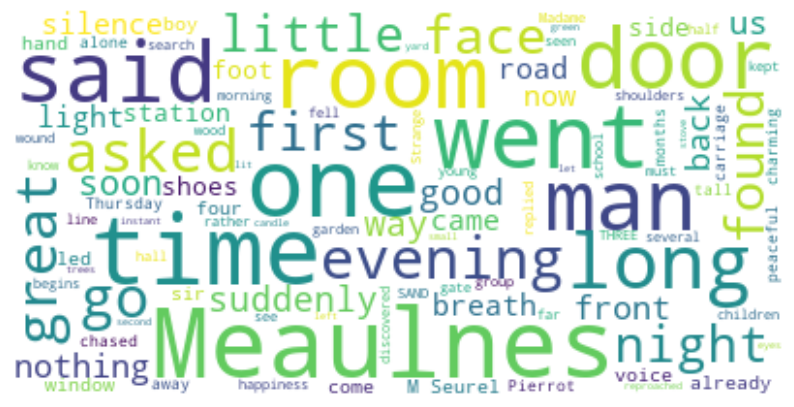

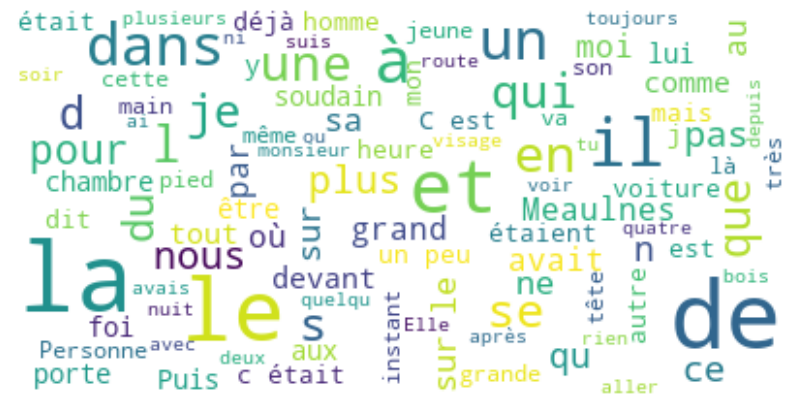

In [2]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt


# generate wordcloud for english text
wordcloud = WordCloud(max_words=100, max_font_size=50, background_color='white')
wordcloud = wordcloud.generate( ' '.join(en_text) )

plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')

plt.show()

wordcloud = WordCloud(max_words=100, max_font_size=50, background_color='white')
wordcloud = wordcloud.generate( ' '.join(fr_text) )

plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')

plt.show()


In [3]:
from transformers import BertTokenizer
from torch.utils.data import DataLoader, TensorDataset, Dataset


tok_src = BertTokenizer.from_pretrained(SRC_CKPT)
tok_tgt = BertTokenizer.from_pretrained(TGT_CKPT)

PAD_ID = tok_tgt.pad_token_id
EOS_ID = tok_tgt.sep_token_id
BOS_ID = tok_tgt.cls_token_id

#note : maybe use Bert from tensorflow API?;more option https://www.tensorflow.org/text/api_docs/python/text/BertTokenizer
# or usi keras API? from tensorflow.keras.preprocessing.text import Tokenizer
# note sure 

def tokenize_src(Batchoftext):
    ''' 
    transform a batch of sentences into token with id and attention mask with help of Bert pretrainmodel
    Bert pretrained model 
    Some text are too long... i think this will cause error, see later
    '''
    # see https://medium.com/axinc-ai/how-tokenizer-parameters-impact-transformers-behavior-8be8030637c6
    Tok = tok_src(Batchoftext,
                    max_length=max_len,
                    #padding='max_length',
                    padding=True,
                    truncation=True,
                    return_tensors='pt'# pytorch tensor
                    )

    return Tok#Tok['input_ids'], Tok['attention_mask']

def tokenize_tgt(Batchoftext):
    ''' 
    same as source, but for targeted language,
    + BOS is not needed for decoder
    + EOS absent in cutted sentence
    '''
    # see https://medium.com/axinc-ai/how-tokenizer-parameters-impact-transformers-behavior-8be8030637c6
    Tok = tok_tgt(Batchoftext,
                    max_length=max_len,
                    padding='max_length',
                    truncation=True,
                    add_special_tokens=False,
                    return_tensors='pt'# pytorch tensor
                    )['input_ids']
    
    Tok_fixed = torch.full_like(Tok, PAD_ID)
    for i in range(Tok.shape[0]):
        y=Tok[i,:]
        y=y[y!=PAD_ID] #remove all padd
        if len(y)<max_len: #add EOS if max length not reached
            y=torch.cat((y,torch.tensor([EOS_ID])),dim=0)
        Tok_fixed[i,:len(y)]=y

    Tok_fixed[Tok_fixed == PAD_ID] = -100
    
    return Tok_fixed




In [4]:


class CustomDataset(Dataset):
    def __init__(self,src_list,tgt_list):
        self.src=src_list
        self.tgt=tgt_list

    def __len__(self):
        return len(self.src)

    def __getitem__(self, index):
        return self.src[index], self.tgt[index]    
        

def collate(batch):
    s, t = zip(*batch)
    z=tokenize_src(s)
    train_input_ids=z['input_ids']
    train_attention_masks=z['attention_mask']
    train_labels_ids=tokenize_tgt(t) 

    return train_input_ids, train_attention_masks, train_labels_ids





#### this two approach should be the same, no ? but first one give errors 

def compute_data_dl(src_list,tgt_list,option=None):
    ''' two method for computing train dataloader, which is used for training'''

    if option==None:
        option=1

    if option==0:

        z=tokenize_src(src_list)
        input_ids=z['input_ids']
        attention_masks=z['attention_mask']
        labels_ids=tokenize_tgt(tgt_list)

        dataset = TensorDataset(input_ids,#type(torch.int64)
                                    attention_masks,
                                    labels_ids
                                    )
        
        dataloader = DataLoader(dataset,
                                batch_size=Batch_size,
                                shuffle=True)

    if option==1:
        dataloader=DataLoader(CustomDataset(src_list,tgt_list),
                                batch_size=Batch_size,
                                shuffle=True,
                                collate_fn=collate)


    return dataloader




train_dataloader=compute_data_dl(src_list=X_train,tgt_list=y_train,option=dl_opt)

val_dataloader=compute_data_dl(src_list=X_test,tgt_list=y_test,option=dl_opt)




In [5]:
#BERT to BERT

#from transformers import BertConfig, BertForMaskedLM , get_linear_schedule_with_warmup
from transformers import  BertGenerationDecoder, EncoderDecoderModel
from transformers import  BertLMHeadModel, AutoModel, BertConfig
import torch.nn as nn
#from sklearn.utils.class_weight import compute_class_weight
import torch
import random



def make_model(case=None):


    # I think best would be to combine any bidirectional text encoder (e.g. BERT) with a autoregressive text decoder (e.g. GPT2).
    # but I want bert2bert for now
    if case==None:
        case=1# bertgenerationdecoder dont work... because???

    #default encoder
    encoder = AutoModel.from_pretrained(SRC_CKPT,
                                        bos_token_id=BOS_ID,
                                        eos_token_id=EOS_ID)
        
    if case==0:
        decoder=BertGenerationDecoder.from_pretrained(TGT_CKPT,
                                                        add_cross_attention=True,
                                                        is_decoder=True,
                                                        bos_token_id=BOS_ID,
                                                        eos_token_id=EOS_ID)


    if case==1:                              
        decoder=BertLMHeadModel.from_pretrained(TGT_CKPT,
                                                add_cross_attention=True,
                                                is_decoder=True,
                                                bos_token_id=BOS_ID,
                                                eos_token_id=EOS_ID)


    if case==2:
        dec_cfg = BertConfig.from_pretrained(TGT_CKPT,
                                            is_decoder=True,
                                            add_cross_attention=True,
                                            bos_token_id=BOS_ID,
                                            eos_token_id=EOS_ID)
        
        decoder=BertLMHeadModel.from_pretrained(TGT_CKPT,config=dec_cfg)

        

    model=EncoderDecoderModel(  encoder=encoder, 
                                decoder=decoder) 
 
    #adding some config 
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    #required special ids for training (right-shift) and decode
    model.config.decoder_start_token_id = BOS_ID
    model.config.eos_token_id = EOS_ID
    model.config.pad_token_id = PAD_ID
    model.config.tie_encoder_decoder = False
    model.config.vocab_size = model.config.decoder.vocab_size
    #tie encoder and decoder only if both  have the exact same parameter names.
    return model



In [6]:
from torch.optim import AdamW
import tensorflow as tf



def generate_trad(model,sentences):
    ''' 
    generate a translation from french to english (for now) by using the EncoderDecoder model 
    '''
    inputs=tokenize_src(list(sentences))

    out=model.generate(  input_ids=inputs['input_ids'], 
                            attention_mask=inputs['attention_mask'],
                            decoder_start_token_id=BOS_ID,
                            eos_token_id=EOS_ID,
                            pad_token_id=PAD_ID,
                            num_beams=4,
                            #max_new_tokens=24,
                            no_repeat_ngram_size=3,
                            repetition_penalty=1.2, 
                            early_stopping=True
                          )
    #print(predic.view(-1))

    return [tok_tgt.decode(o, skip_special_tokens=True) for o in out]

    #return  out


def run_quick_test(train_dl,case):
    ''' A small (aka 'short') to see how the choice of  ofmodel decoder impact the translation via texte generation '''
    ''' this is on the same sub data over all runs'''
    
    
    model=make_model(case)
    optimizer = AdamW(model.parameters(), lr=LR*5,weight_decay=wd)    
    model.train()
    
    for i in range(EPOCHS):
        loss=0
        for sent_id,att_mask, labels in train_dl:
            optimizer.zero_grad()
            out=model.forward(  input_ids=sent_id,#.unsqueeze(0),
                                attention_mask=att_mask,#.unsqueeze(0),
                                labels=labels,#.unsqueeze(0),
                                output_attentions=True ) 
            out.loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            loss+=out.loss

        #zz=tf.math.argmax(out.logits.detach().numpy(),axis=-1)
        Loss=loss/len(train_dl)
        print(f'run {i}, loss= {Loss}')
            
        i=i+1

    model.eval()


    n=3
    #print(sent_id[s])
    phrases=[tok_src.decode(sent,skip_special_tokens=True) for sent in sent_id[:n]]#sent_id have CLS
    trad=generate_trad(model=model,sentences=phrases)
    for i in range(n):
        print('Sentence to translate: ',phrases[i])#sentence to translate
        print('Generated translation: ', trad[i])
        print('----')


    del model 


n=Batch_size*4
subtrain_dataloader=DataLoader(CustomDataset(X_train[:n],y_train[:n]),
                             batch_size=Batch_size,
                             shuffle=False,###false to have the same sentences to translate
                             collate_fn=collate)

#run_quick_test(subtrain_dataloader,case=0)# try BertGenerationDecoder # does not work with optimizer, why?





In [7]:
run_quick_test(subtrain_dataloader,case=1) # try BertLMHeadModel


Some weights of BertLMHeadModel were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['bert.encoder.layer.0.crossattention.output.LayerNorm.bias', 'bert.encoder.layer.0.crossattention.output.LayerNorm.weight', 'bert.encoder.layer.0.crossattention.output.dense.bias', 'bert.encoder.layer.0.crossattention.output.dense.weight', 'bert.encoder.layer.0.crossattention.self.key.bias', 'bert.encoder.layer.0.crossattention.self.key.weight', 'bert.encoder.layer.0.crossattention.self.query.bias', 'bert.encoder.layer.0.crossattention.self.query.weight', 'bert.encoder.layer.0.crossattention.self.value.bias', 'bert.encoder.layer.0.crossattention.self.value.weight', 'bert.encoder.layer.1.crossattention.output.LayerNorm.bias', 'bert.encoder.layer.1.crossattention.output.LayerNorm.weight', 'bert.encoder.layer.1.crossattention.output.dense.bias', 'bert.encoder.layer.1.crossattention.output.dense.weight', 'bert.encoder.layer.1.crossattention.self.key.bia

run 0, loss= 8.318399429321289
run 1, loss= 6.95190954208374
run 2, loss= 6.614739894866943
run 3, loss= 6.249460220336914
run 4, loss= 5.8326096534729
run 5, loss= 5.355703353881836
run 6, loss= 4.857154846191406
run 7, loss= 4.358301162719727
run 8, loss= 3.80749773979187
run 9, loss= 3.4029033184051514
run 10, loss= 2.9860641956329346
run 11, loss= 2.6321346759796143
run 12, loss= 2.368314027786255
run 13, loss= 2.059385299682617
run 14, loss= 1.7615132331848145
run 15, loss= 1.593052625656128
run 16, loss= 1.3665153980255127
run 17, loss= 1.093746304512024
run 18, loss= 0.9279358386993408
run 19, loss= 0.956193208694458
run 20, loss= 0.727280855178833
run 21, loss= 0.655088484287262
run 22, loss= 0.5673196315765381
run 23, loss= 0.49978670477867126
Sentence to translate:  a huit heures et demie, a l ’ instant ou m. seurel allait donner le signal d ’ entrer, nous arrivames tout essouffles pour nous mettre sur les rangs.
Generated translation:  At once, being accustomed to to poacher

In [8]:
run_quick_test(subtrain_dataloader,case=2) # another, which should be the same as case=1... but it is not 


Some weights of BertLMHeadModel were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['bert.encoder.layer.0.crossattention.output.LayerNorm.bias', 'bert.encoder.layer.0.crossattention.output.LayerNorm.weight', 'bert.encoder.layer.0.crossattention.output.dense.bias', 'bert.encoder.layer.0.crossattention.output.dense.weight', 'bert.encoder.layer.0.crossattention.self.key.bias', 'bert.encoder.layer.0.crossattention.self.key.weight', 'bert.encoder.layer.0.crossattention.self.query.bias', 'bert.encoder.layer.0.crossattention.self.query.weight', 'bert.encoder.layer.0.crossattention.self.value.bias', 'bert.encoder.layer.0.crossattention.self.value.weight', 'bert.encoder.layer.1.crossattention.output.LayerNorm.bias', 'bert.encoder.layer.1.crossattention.output.LayerNorm.weight', 'bert.encoder.layer.1.crossattention.output.dense.bias', 'bert.encoder.layer.1.crossattention.output.dense.weight', 'bert.encoder.layer.1.crossattention.self.key.bia

run 0, loss= 8.486861228942871
run 1, loss= 6.933977127075195
run 2, loss= 6.5496015548706055
run 3, loss= 6.087094306945801
run 4, loss= 5.533915996551514
run 5, loss= 5.055891036987305
run 6, loss= 4.477749347686768
run 7, loss= 4.0621442794799805
run 8, loss= 3.4951236248016357
run 9, loss= 3.120103359222412
run 10, loss= 2.7662580013275146
run 11, loss= 2.389890432357788
run 12, loss= 2.101217746734619
run 13, loss= 1.7336987257003784
run 14, loss= 1.5489336252212524
run 15, loss= 1.3305970430374146
run 16, loss= 1.1665980815887451
run 17, loss= 0.9729766249656677
run 18, loss= 0.8602367639541626
run 19, loss= 0.7816742062568665
run 20, loss= 0.6653964519500732
run 21, loss= 0.6360058784484863
run 22, loss= 0.5687320828437805
run 23, loss= 0.45319604873657227
Sentence to translate:  a huit heures et demie, a l ’ instant ou m. seurel allait donner le signal d ’ entrer, nous arrivames tout essouffles pour nous mettre sur les rangs.
Generated translation:  At half - past eight, just a

In [9]:
run_quick_test(train_dataloader,case=2) # 


Some weights of BertLMHeadModel were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['bert.encoder.layer.0.crossattention.output.LayerNorm.bias', 'bert.encoder.layer.0.crossattention.output.LayerNorm.weight', 'bert.encoder.layer.0.crossattention.output.dense.bias', 'bert.encoder.layer.0.crossattention.output.dense.weight', 'bert.encoder.layer.0.crossattention.self.key.bias', 'bert.encoder.layer.0.crossattention.self.key.weight', 'bert.encoder.layer.0.crossattention.self.query.bias', 'bert.encoder.layer.0.crossattention.self.query.weight', 'bert.encoder.layer.0.crossattention.self.value.bias', 'bert.encoder.layer.0.crossattention.self.value.weight', 'bert.encoder.layer.1.crossattention.output.LayerNorm.bias', 'bert.encoder.layer.1.crossattention.output.LayerNorm.weight', 'bert.encoder.layer.1.crossattention.output.dense.bias', 'bert.encoder.layer.1.crossattention.output.dense.weight', 'bert.encoder.layer.1.crossattention.self.key.bia

run 0, loss= 7.608529090881348
run 1, loss= 6.56284236907959
run 2, loss= 6.0414323806762695
run 3, loss= 5.240926742553711
run 4, loss= 4.454012870788574
run 5, loss= 3.8904080390930176
run 6, loss= 3.200709819793701
run 7, loss= 2.6629035472869873
run 8, loss= 2.2133066654205322
run 9, loss= 1.8439260721206665
run 10, loss= 1.5734903812408447
run 11, loss= 1.3095481395721436
run 12, loss= 1.0169038772583008
run 13, loss= 0.8904752731323242
run 14, loss= 0.763188362121582
run 15, loss= 0.601660966873169
run 16, loss= 0.5394204258918762
run 17, loss= 0.46819624304771423
run 18, loss= 0.4349448084831238
run 19, loss= 0.4293972849845886
run 20, loss= 0.3564756512641907
run 21, loss= 0.2948169708251953
run 22, loss= 0.28989118337631226
run 23, loss= 0.28016287088394165
Sentence to translate:  la pluie etait tombee tout le jour, pour ne cesser qu ’ au soir.
Generated translation:  Rain had fallen all day ; it did not stop till evening.
----
Sentence to translate:  c ’ etait la fin de la bo

In [10]:
from torch.optim import AdamW
import torch.nn.functional as F
from transformers import get_linear_schedule_with_warmup


model=make_model(case=2)

optimizer = AdamW(model.parameters(), lr=LR,weight_decay=wd)

#
# scheduler = get_linear_schedule_with_warmup(optimizer,
#                                              num_warmup_steps=len(train_dataloader)//Batch_size *10,
#                                              num_training_steps=len(train_dataloader)//Batch_size *EPOCHS*2
#                                              )
# # define the loss function
#cross_entropy  = nn.NLLLoss() #Negative log likelihood loss ; good for classification

def train_model():
    ''' 
    BERT model - train the model
    '''
    model.train()

    total_loss = 0
    for step, batch in enumerate(train_dataloader):

        sent_id, mask, labels = batch

        # clear previously calculated gradients 
        optimizer.zero_grad()        

        # get model predictions for the current batch
        out = model(input_ids=sent_id,
                      attention_mask=mask,#attention mask is important because of  padding
                      labels=labels
                      )

        # log_preds = F.log_softmax(preds.logits, dim=-1)
        # loss = cross_entropy(log_preds.view(-1, tokenizer.vocab_size), 
        #                     labels.view(-1)
        out.loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        total_loss +=out.loss.item()
        optimizer.step()
    
    #adjust learning rate for next training loop
    #scheduler.step()
    
    avg_loss = total_loss / len(train_dataloader)

    return avg_loss


def evaluate_model():
    ''' 
    BERT model - evaluate the model
    '''
    model.eval()
    total_loss=0

    for step, batch in enumerate(val_dataloader):

        sent_id, mask, labels = batch

        # deactivate autograd
        with torch.no_grad(): # do NOT compute gradient; gradient is computed in training only

            # get model predictions for the current batch
            preds = model(  input_ids=sent_id,
                            attention_mask=mask,#attention mask is important because of  padding
                            labels=labels
                            )
            
            loss=preds.loss
            total_loss = total_loss + loss.item()

    avg_loss = total_loss / len(train_dataloader)

    return avg_loss

Some weights of BertLMHeadModel were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['bert.encoder.layer.0.crossattention.output.LayerNorm.bias', 'bert.encoder.layer.0.crossattention.output.LayerNorm.weight', 'bert.encoder.layer.0.crossattention.output.dense.bias', 'bert.encoder.layer.0.crossattention.output.dense.weight', 'bert.encoder.layer.0.crossattention.self.key.bias', 'bert.encoder.layer.0.crossattention.self.key.weight', 'bert.encoder.layer.0.crossattention.self.query.bias', 'bert.encoder.layer.0.crossattention.self.query.weight', 'bert.encoder.layer.0.crossattention.self.value.bias', 'bert.encoder.layer.0.crossattention.self.value.weight', 'bert.encoder.layer.1.crossattention.output.LayerNorm.bias', 'bert.encoder.layer.1.crossattention.output.LayerNorm.weight', 'bert.encoder.layer.1.crossattention.output.dense.bias', 'bert.encoder.layer.1.crossattention.output.dense.weight', 'bert.encoder.layer.1.crossattention.self.key.bia

In [11]:
### FINE TUNING

best_loss=1e6 #a really high value

for epoch in range(EPOCHS):

    train_loss=train_model()
    valid_loss=evaluate_model()
    print(f'Epoch {epoch+1}/{EPOCHS} - Training loss: {train_loss} - Validation loss: {valid_loss}')

    if valid_loss< best_loss:
        best_loss = valid_loss
        best_model = model

best_model=model


#model_save_path = "bert_translation_model.pt"
#torch.save(best_model, model_save_path)


Epoch 1/24 - Training loss: 8.465181732177735 - Validation loss: 2.1007102489471436
Epoch 2/24 - Training loss: 7.1063079833984375 - Validation loss: 1.9956544876098632
Epoch 3/24 - Training loss: 6.716081142425537 - Validation loss: 1.9015349388122558
Epoch 4/24 - Training loss: 6.3094847202301025 - Validation loss: 1.8082602500915528
Epoch 5/24 - Training loss: 5.954659700393677 - Validation loss: 1.7201151847839355
Epoch 6/24 - Training loss: 5.617684316635132 - Validation loss: 1.6475144863128661
Epoch 7/24 - Training loss: 5.270824193954468 - Validation loss: 1.5806694984436036
Epoch 8/24 - Training loss: 4.931565046310425 - Validation loss: 1.511463451385498
Epoch 9/24 - Training loss: 4.691236352920532 - Validation loss: 1.5493360042572022
Epoch 10/24 - Training loss: 4.3898169040679935 - Validation loss: 1.5492709159851075
Epoch 11/24 - Training loss: 4.261548471450806 - Validation loss: 1.4940944194793702
Epoch 12/24 - Training loss: 3.9949949979782104 - Validation loss: 1.546

In [15]:
#model_save_path = "bert_translation_model.pt"
#model=torch.load(model_save_path, weights_only=False)
#model.eval()

#from torchsummary import summary
#summary(model,model.l)
#model.modules


sentence= X_test[:3]
trad=generate_trad(model,sentence)
for i in range(len(sentence)):
    print('sentence: ',sentence[i])
    print('traduction: ', trad[i])


sentence:  Un sentier profond s’ouvrait dans la haie :
traduction:  The village village has changed changed to times.
sentence:  Il y a trois mois, j’ai voulu me tirer une balle dans la tête et c’est ce qui vous explique ce bandeau, sur le front, comme un mobile de la Seine, en 1870…
traduction:  For an hour, I found myself forever forever, I have long since since since.
sentence:  M. Seurel est là…
traduction:  He asked him him!
